In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers

2023-08-11 14:20:04.190963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 14:20:05.097149: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student1/miniconda3/envs/Accident_detection/lib/python3.9/site-packages/cv2/../../lib64:/home/student1/openssl/lib:/home/student1/openssl/lib:
2023-08-11 14:20:05.097284: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory

In [23]:
batch_size = 100
img_height = 250
img_width = 250

In [24]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


In [25]:
class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

time_steps = 5  # Number of time steps for the ConvLSTM
img_height = 250
img_width = 250
img_shape = (img_height, img_width, 3)
batch_size = 32  # Your chosen batch size

def preprocess_fn(images, labels):
    resized_images = tf.image.resize(images, (img_height, img_width))
    expanded_images = tf.expand_dims(resized_images, axis=1)  # Add time step dimension
    repeated_images = tf.tile(expanded_images, [1, time_steps, 1, 1, 1])  # Repeat for each time step
    return repeated_images, labels

# Apply preprocessing to the datasets
training_ds = training_ds.map(preprocess_fn)
validation_ds = validation_ds.map(preprocess_fn)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
    layers.TimeDistributed(base_model, input_shape=(time_steps,) + img_shape),  # Apply ConvLSTM to the base model
    layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu')),
    layers.TimeDistributed(layers.Conv2D(64, 3, activation='relu')),
    layers.TimeDistributed(layers.Conv2D(128, 3, activation='relu')),
    layers.TimeDistributed(layers.Flatten()),
    layers.LSTM(64, return_sequences=False),  # Use LSTM to process the sequences
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [27]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 10)

Epoch 1/10
8/8 [==============================] - 14s 875ms/step - loss: 0.7925 - accuracy: 0.5247 - val_loss: 0.6655 - val_accuracy: 0.6531
Epoch 2/10
8/8 [==============================] - 5s 616ms/step - loss: 0.6588 - accuracy: 0.5954 - val_loss: 0.5994 - val_accuracy: 0.7041
Epoch 3/10
8/8 [==============================] - 5s 621ms/step - loss: 0.5850 - accuracy: 0.7181 - val_loss: 0.5269 - val_accuracy: 0.7755
Epoch 4/10
8/8 [==============================] - 5s 624ms/step - loss: 0.4530 - accuracy: 0.7927 - val_loss: 0.5780 - val_accuracy: 0.7143
Epoch 5/10
8/8 [==============================] - 5s 624ms/step - loss: 0.3918 - accuracy: 0.8167 - val_loss: 0.6356 - val_accuracy: 0.6837
Epoch 6/10
8/8 [==============================] - 5s 622ms/step - loss: 0.3149 - accuracy: 0.8799 - val_loss: 0.3731 - val_accuracy: 0.8367
Epoch 7/10
8/8 [==============================] - 5s 621ms/step - loss: 0.2348 - accuracy: 0.9014 - val_loss: 0.5860 - val_accuracy: 0.7551
Epoch 8/10
8/8 [===

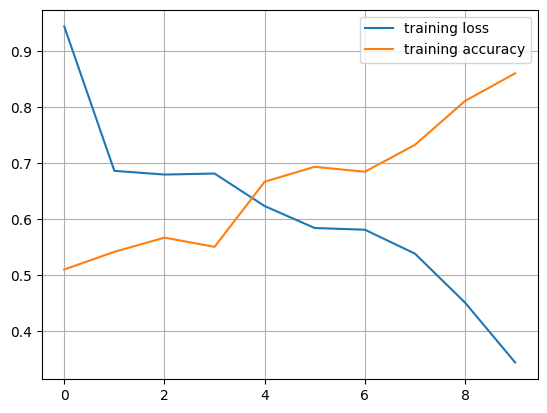

In [15]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

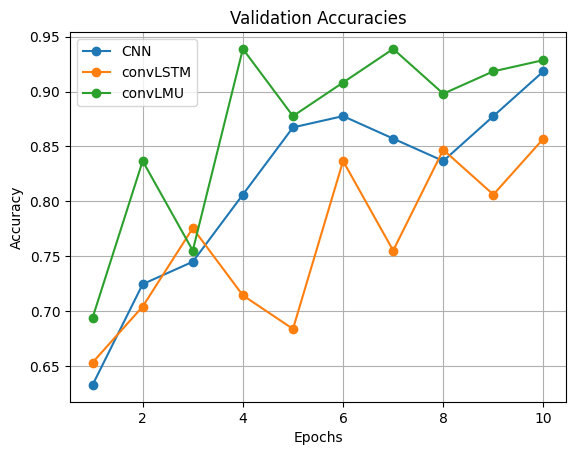

In [28]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

cnn_val_accuracies = [0.6327, 0.7245, 0.7449, 0.8061, 0.8673, 0.8776, 0.8571, 0.8367, 0.8776, 0.9184]
convlstm_val_accuracies = [0.6531, 0.7041, 0.7755, 0.7143, 0.6837, 0.8367, 0.7551, 0.8469, 0.8061, 0.8571]
convlmu_val_accuracies = [0.6939, 0.8367, 0.7551, 0.9388, 0.8776, 0.9082, 0.9388, 0.8980, 0.9184, 0.9286]

plt.plot(epochs, cnn_val_accuracies, marker='o', label='CNN')
plt.plot(epochs, convlstm_val_accuracies, marker='o', label='convLSTM')
plt.plot(epochs, convlmu_val_accuracies, marker='o', label='convLMU')

plt.title('Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
